In [1]:
import pyedflib # ref: https://pyedflib.readthedocs.io/en/latest/
import pandas as pd
import numpy as np
import os
import fnmatch
from datetime import timedelta

In [2]:
def clip_edf_data(psg_id, hypnogram_id, read_folder, write_folder):
    signal_path = os.path.join(read_folder, f'{psg_id}-PSG.edf')
    label_path = os.path.join(read_folder, f'{hypnogram_id}-Hypnogram.edf')
    # read EDF files
    edf_signal = pyedflib.EdfReader(signal_path)
    edf_label = pyedflib.EdfReader(label_path)

    # read data
    annotations = edf_label.readAnnotations()
    start = edf_signal.getStartdatetime()
    signals, frequencies = edf_signal.getSignalLabels(), edf_signal.getSampleFrequencies()
    # ? INFO: ['EEG Fpz-Cz', 'EEG Pz-Oz', 'EOG horizontal', 'Resp oro-nasal', 'EMG submental', 'Temp rectal', 'Event marker'] [100., 100., 100.,   1.,   1.,   1.,   1.] in Hz
    
    data = []
    for (ch_idx, sig_name), freq in zip(enumerate(signals), frequencies):
        sig = edf_signal.readSignal(chn=ch_idx)
        idx = pd.date_range(start=start, periods=sig.shape[0], freq=pd.Timedelta(1 / freq, unit="s"))
        data += [pd.Series(sig, index=idx, name=sig_name)]

    # create DataFrames
    annotations_df = pd.DataFrame(annotations)
    annotations_df = annotations_df.T
    # Onset, Duration = START, END
    annotations_df.rename(columns={0: "Onset", 1: "Duration", 2:"Annotations"}, inplace=True)
    # display(annotations_df)
    # edf_signal.close()
    # del edf_signal
    # edf_label.close()
    # del edf_label
    # return

    # 100Hz and 1Hz
    signal_df_100 =pd.concat(data[0:3], axis=1)
    signal_df_1 =pd.concat(data[3:], axis=1)

    # create signal clips and annotation clips
    signal_clips_100 = []
    signal_clips_1 = []
    annotation_clips = []
    durations = []
    start_times = []
    for i in range(len(annotations_df) - 2):
        # Searching for W->1->X sequence
        if (annotations_df['Annotations'].iloc[i] == "Sleep stage W" and annotations_df['Annotations'].iloc[i+1] == "Sleep stage 1"):
            print(i, end=' ')
            # Cutting the sequence
            annotation_clip = annotations_df.iloc[i:i+3, :]

            if annotation_clip['Onset'].iloc[0] == 0.0:
                print('OAQ')
                annotation_clip = annotation_clip.copy()
                annotation_clip['Onset'].iloc[0] = annotation_clip['Onset'].iloc[1] - 600.0
                annotation_clip['Duration'].iloc[0] = 600.0

            if annotation_clip['Duration'].iloc[2] > 600.0:
                annotation_clip = annotation_clip.copy()
                annotation_clip['Duration'].iloc[2] = 600.0

            start_time = start + timedelta(seconds = int(annotation_clip['Onset'].iloc[0]))
            end_time = start + timedelta(seconds = int((annotation_clip['Onset'].iloc[2] + annotation_clip['Duration'].iloc[2])))
            durations.append(end_time-start_time)
            start_times.append(start_time)

            signal_clip_100 = signal_df_100.loc[start_time:end_time, :]
            signal_clip_1 = signal_df_1.loc[start_time:end_time, :]
            signal_clips_100.append(signal_clip_100)
            signal_clips_1.append(signal_clip_1)

            annotation_clip = annotation_clip.copy()
            annotation_clip.loc[:, 'Onset'] = annotation_clip['Onset'] - annotation_clip['Onset'].iloc[0]
            annotation_clips.append(annotation_clip)
        break

    # write EDF files
    N = len(durations)

    for i in range(N):
        channel_info = []
        data_list = []
        for j in range(7):
            channel = j
            print(edf_signal.getLabel(channel))
            ch_dict = {
                'label': edf_signal.getLabel(channel),
                'dimension': edf_signal.getPhysicalDimension(channel),
                'sample_rate': edf_signal.getSampleFrequency(channel),
                'physical_max': edf_signal.getPhysicalMaximum(channel),
                'physical_min': edf_signal.getPhysicalMinimum(channel),
                'digital_max': edf_signal.getDigitalMaximum(channel),
                'digital_min': edf_signal.getDigitalMinimum(channel),
                'transducer': edf_signal.getTransducer(channel),
                'prefilter':edf_signal.getPrefilter(channel)
                }
            # print(ch_dict)
            channel_info.append(ch_dict)
            if j < 3:
                data_list.append(signal_clips_100[i][edf_signal.getLabel(channel)].values)
            else:
                data_list.append(signal_clips_1[i][edf_signal.getLabel(channel)].values)

        psg_file = os.path.join(write_folder, f'{psg_id[0:6]}{i:02d}{psg_id[6:8]}-PSG.edf')
        # print(psg_file)
        psg_edf = pyedflib.EdfWriter(psg_file, 7, file_type=pyedflib.FILETYPE_EDFPLUS)
        psg_edf.setSignalHeaders(channel_info)
        psg_edf.setStartdatetime(start_times[i])
        # psg_edf.setDatarecordDuration(100000)

        psg_edf.writeSamples(data_list)
        psg_edf.close()
        del psg_edf

        hypnogram_file = os.path.join(write_folder, f'{hypnogram_id[0:6]}{i:02d}{hypnogram_id[6:8]}-Hypnogram.edf')
        hypnogram_edf = pyedflib.EdfWriter(hypnogram_file, 7, file_type=pyedflib.FILETYPE_EDFPLUS)
        hypnogram_edf.setSignalHeaders(channel_info)
        hypnogram_edf.setStartdatetime(start_times[i])
        # hypnogram_edf.setDatarecordDuration(100000)

        for j in range(len(annotation_clips[i])):
            onset = annotation_clips[i]['Onset'].iloc[j]
            duration = annotation_clips[i]['Duration'].iloc[j]
            annotation = annotation_clips[i]['Annotations'].iloc[j]
            # print(f'Durations:{duration}, Onset:{onset}, Annotation:{annotation}')
            hypnogram_edf.writeAnnotation(onset, duration, annotation)
        hypnogram_edf.close()
        del hypnogram_edf

    edf_signal.close()
    del edf_signal
    edf_label.close()
    del edf_label



In [3]:
read_folder = './sleep-cassette/'
write_folder = './clips/'

pattern1 = '*-PSG.edf'
pattern2 = '*-Hypnogram.edf'

psg_list = sorted([f for f in os.listdir(read_folder) if fnmatch.fnmatch(f, pattern1)])
hypnogram_list = sorted([f for f in os.listdir(read_folder) if fnmatch.fnmatch(f, pattern2)])

for i in range(len(psg_list)):
    clip_edf_data(
        psg_id=psg_list[i][0:8],
        hypnogram_id=hypnogram_list[i][0:8],
        read_folder = read_folder,
        write_folder = write_folder
    )


0 OAQ
EEG Fpz-Cz
EEG Pz-Oz
EOG horizontal
Resp oro-nasal
EMG submental
Temp rectal
Event marker
0 OAQ
EEG Fpz-Cz
EEG Pz-Oz
EOG horizontal
Resp oro-nasal
EMG submental
Temp rectal
Event marker
0 OAQ
EEG Fpz-Cz
EEG Pz-Oz
EOG horizontal
Resp oro-nasal
EMG submental
Temp rectal
Event marker
0 OAQ
EEG Fpz-Cz
EEG Pz-Oz
EOG horizontal
Resp oro-nasal
EMG submental
Temp rectal
Event marker
0 OAQ
EEG Fpz-Cz
EEG Pz-Oz
EOG horizontal
Resp oro-nasal
EMG submental
Temp rectal
Event marker
0 OAQ
EEG Fpz-Cz
EEG Pz-Oz
EOG horizontal
Resp oro-nasal
EMG submental
Temp rectal
Event marker
0 OAQ
EEG Fpz-Cz
EEG Pz-Oz
EOG horizontal
Resp oro-nasal
EMG submental
Temp rectal
Event marker
0 OAQ
EEG Fpz-Cz
EEG Pz-Oz
EOG horizontal
Resp oro-nasal
EMG submental
Temp rectal
Event marker
0 OAQ
EEG Fpz-Cz
EEG Pz-Oz
EOG horizontal
Resp oro-nasal
EMG submental
Temp rectal
Event marker
0 OAQ
EEG Fpz-Cz
EEG Pz-Oz
EOG horizontal
Resp oro-nasal
EMG submental
Temp rectal
Event marker
0 OAQ
EEG Fpz-Cz
EEG Pz-Oz
EOG horizonta

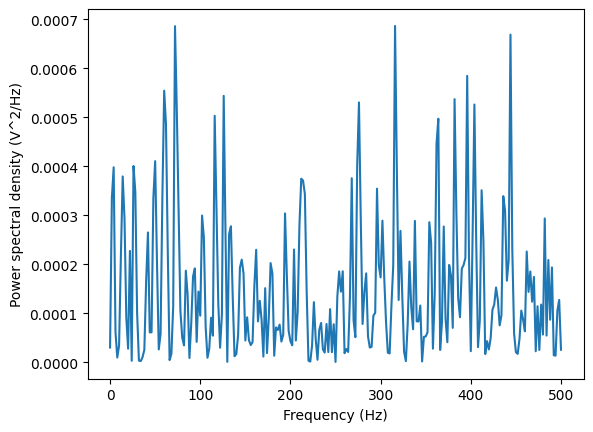

In [4]:
from scipy import signal
import matplotlib.pyplot as plt
import numpy as np

# Generate some example data
window = np.random.rand(500)
fs = 1000

# Calculate the PSD using Welch's method
freqs, psd = signal.welch(window, fs=fs, nperseg=len(window))

# Plot the PSD estimate
plt.plot(freqs, psd)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power spectral density (V^2/Hz)')
plt.show()